<a href="https://colab.research.google.com/github/quirky-coder/Crowd-Movement-Segmentation-from-Video-Footage/blob/main/DIP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

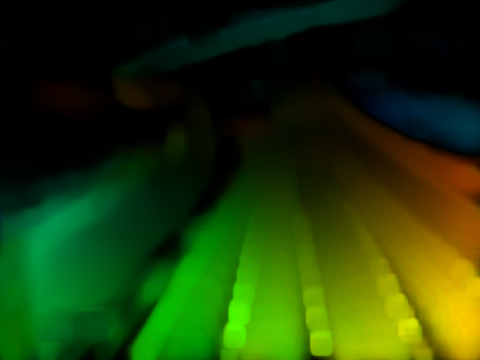

In [34]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow


# The video feed is read in as
# a VideoCapture object
cap = cv.VideoCapture("/content/701-111_l.mov")

# calculating the no. of frames
length = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

# getting the first frame
ret, first_frame = cap.read()

# initializing streakflow vector with zeroes
y,x = first_frame.shape[:2]

streak_flow = np.zeros((y,x,2))

# converting RGB to gray
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
  
# Creates an image filled with zero
# intensities with the same dimensions 
# as the frame
mask = np.zeros_like(first_frame)
  
# Sets image saturation to maximum
mask[..., 1] = 255

  
while (cap.isOpened()):
      
    # ret = a boolean return value from getting
    # the frame, frame = the current frame being
    # projected in the video
    ret, frame = cap.read()

    if ret==False:
      break
      
      
    # Converts each frame to grayscale - we previously 
    # only converted the first frame to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
      
    # Calculates dense optical flow by Farneback method
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, 
                                       None,
                                       0.5, 3, 15, 3, 5, 1.2, 0)
    
    streak_flow = np.add(streak_flow, flow)
      
    # Updates previous frame
    prev_gray = gray

      
    # Frames are read by intervals of 1 millisecond. The
    # programs breaks out of the while loop when the
    # user presses the 'q' key
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

streak_flow = streak_flow/length

# Computes the magnitude and angle of the 2D vectors
magnitude, angle = cv.cartToPolar(streak_flow[..., 0], streak_flow[..., 1])


mask[..., 0] = angle * 180 / np.pi / 2

mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)

# Converts HSV to RGB (BGR) color representation
rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)

cv2_imshow(rgb)

# The following frees up resources and
# closes all windows
cap.release()
cv.destroyAllWindows()




In [35]:
import matplotlib.pyplot as plt
import matplotlib.colors

step = 11

U = streak_flow[::step, ::step, 0]
V = streak_flow[::step, ::step, 1]

angle1 = angle[::step, ::step] 
magnitude1 = magnitude[::step, ::step]   
max_abs = np.max(magnitude1)


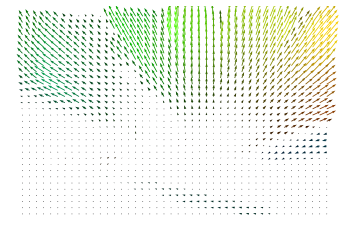

In [36]:

def vector_to_rgb(angle_t, absolute_t):
    """Get the rgb value for the given `angle` and the `absolute` value

    Parameters
    ----------
    angle : float
        The angle in radians
    absolute : float
        The absolute value of the gradient
    
    Returns
    -------
    array_like
        The rgb value as a tuple with values [0..1]
    """
    global max_abs

    # normalize angle
    angle_t = angle_t % (2 * np.pi)
    if angle_t < 0:
        angle_t += 2 * np.pi

    return matplotlib.colors.hsv_to_rgb((angle_t / 2 / np.pi, 
                                         1, 
                                         absolute_t / max_abs))

c = np.array(list(map(vector_to_rgb, angle1.flatten(), magnitude1.flatten())))


#for downloading
img2 = plt.quiver(U, V,color=c)
plt.axis('off')
name="streaklines"
plt.savefig(name,dpi = 200, bbox_inches='tight', pad_inches=0)
plt.show()


#for showing here
# fig, ax = plt.subplots(figsize=(25,9))

# ax.quiver(X, Y, U, V, color=c)
# name="streaklines"
# plt.savefig(name, bbox_inches='tight', pad_inches=0)
# ax.set_title('Quiver plot')
# plt.show()


In [37]:
#Flipping the image across x axis

te = cv.imread("streaklines.png", cv.IMREAD_COLOR)

te1 = cv.flip(te, 0)

cv.imwrite("streaklines.png", te1)

print(te.shape)

(604, 930, 3)


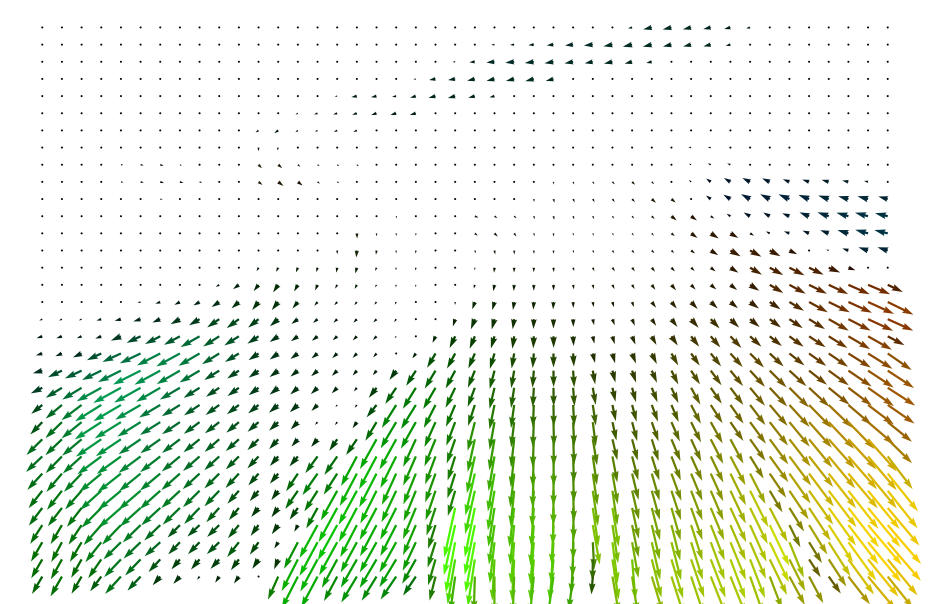

In [38]:
lines = cv.imread("streaklines.png", cv.IMREAD_COLOR)

cv2_imshow(lines)

cv.destroyAllWindows()

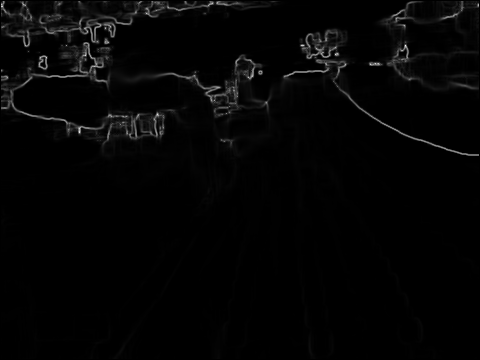

In [39]:

#compute it in only 8 neighbourhood
sim = np.zeros_like(angle)

c = np.cos(angle)

a,b = sim.shape

for y,x in np.ndindex(sim.shape):
  if x!=0 and x!=b-1 and y!=0 and y!=a-1:
    for x1 in range(-1, 2):
      for y1 in range(-1, 2):
        sim[y,x] += abs(c[y,x] - c[y+x1,x+y1])

sim1 = cv.normalize(sim, None, 0, 255, cv.NORM_MINMAX)

cv2_imshow(sim1)

# # # The following frees up resources and
# # # closes all windows
cap.release()
cv.destroyAllWindows()

Here make the motion part blue and others red as demonstrated in the assignment

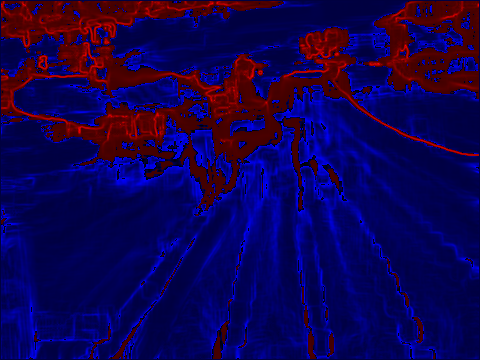

In [40]:


sim_im = np.zeros_like(mask)

# sim_im[...,2] = 127
sim_im[...,1] = 255

for y,x in np.ndindex(sim1.shape):
  if sim1[y,x]<3:
    sim_im[y,x,0] = 120
    sim_im[y,x,2] = (4+sim1[y,x])**3

  else:
    sim_im[y,x,0] = 0
    if (64+sim1[y,x])>255:
      sim_im[y,x,2] = sim1[y,x]
    else:
      sim_im[y,x,2] = sim1[y,x] + 64

  
rgb1 = cv.cvtColor(sim_im, cv.COLOR_HSV2BGR)

cv2_imshow(rgb1)

# # # The following frees up resources and
# # # closes all windows
cap.release()
cv.destroyAllWindows()

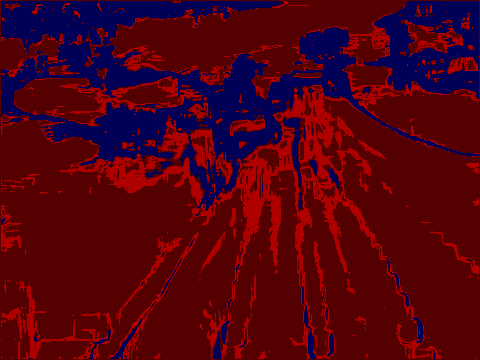

In [41]:
img = cv.cvtColor(rgb1,cv.COLOR_BGR2RGB)
twoDimage = img.reshape((-1,3))
twoDimage = np.float32(twoDimage)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
attempts=10

ret,label,center=cv.kmeans(twoDimage,K,None,criteria,attempts,cv.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

cv2_imshow(result_image)

# # # The following frees up resources and
# # # closes all windows

cv.destroyAllWindows()

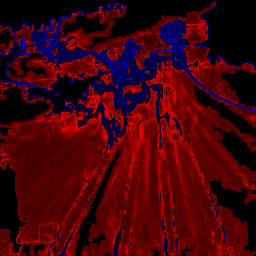

In [42]:
#Contour method
img = cv.resize(rgb1,(256,256))

gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
_,thresh = cv.threshold(gray, np.mean(gray), 255, cv.THRESH_BINARY_INV)
edges = cv.dilate(cv.Canny(thresh,0,255),None)

cnt = sorted(cv.findContours(edges, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)[-2], key=cv.contourArea)[-1]
mask = np.zeros((256,256), np.uint8)
masked = cv.drawContours(mask, [cnt],-1, 255, -1)

dst = cv.bitwise_and(img, img, mask=mask)
segmented = cv.cvtColor(dst, cv.COLOR_BGR2RGB)

cv2_imshow(segmented)

# # # The following frees up resources and
# # # closes all windows

cv.destroyAllWindows()




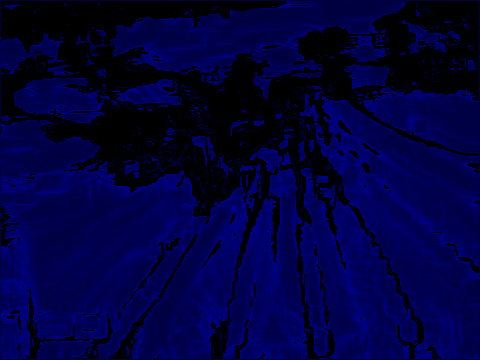

In [43]:
#Thresholding

from skimage.filters import threshold_otsu

img_rgb=cv.cvtColor(rgb1,cv.COLOR_BGR2RGB)
img_gray=cv.cvtColor(img_rgb,cv.COLOR_RGB2GRAY)

def filter_image(image, mask):
    r = image[:,:,0] * mask
    g = image[:,:,1] * mask
    b = image[:,:,2] * mask
    return np.dstack([r,g,b])

thresh = threshold_otsu(img_gray)
img_otsu  = img_gray < thresh
filtered = filter_image(rgb1, img_otsu)

cv2_imshow(filtered)

# # # The following frees up resources and
# # # closes all windows

cv.destroyAllWindows()

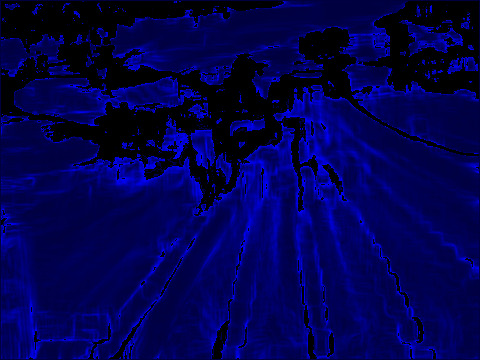

In [44]:
#Color Masking

rgb_img = cv.cvtColor(rgb1, cv.COLOR_BGR2RGB)
hsv_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2HSV)

light_blue = (90, 70, 50)
dark_blue = (128, 255, 255)
# You can use the following values for green
# light_green = (40, 40, 40)
# dark_greek = (70, 255, 255)
mask = cv.inRange(hsv_img, light_blue, dark_blue)

result = cv.bitwise_and(rgb1, rgb1, mask=mask)

cv2_imshow(result)

# # # The following frees up resources and
# # # closes all windows

cv.destroyAllWindows()